In [ ]:
# Mount drive to save stuff there for later
from google.colab import drive, files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Upload kaggle api key
! pip install -q kaggle
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Fetch train and test data from kaggle
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

! mkdir train
! unzip train.zip -d train > downloadlog.txt

! mkdir test
! unzip test.zip -d test >> downloadlog.txt

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 42.6MB/s]
 99% 536M/544M [00:03<00:00, 192MB/s]
100% 544M/544M [00:04<00:00, 142MB/s]
 98% 265M/271M [00:02<00:00, 126MB/s]
100% 271M/271M [00:02<00:00, 134MB/s]


In [ ]:
import glob
import os
import cv2
import math
import datetime
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
#from keras.callbacks import ReduceLROnPlateau
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from pylab import rcParams

In [ ]:
import tempfile

class LearningRateFinder:

    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        # initialize our list of learning rates and losses respectively
        self.lrs = []
        self.losses = []
        # initialize our learning rate multiplier, average loss, best loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator", "DataFrameIterator", "Iterator", "Sequence"]
        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses

    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add it to the list of learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        # grab the loss at the end of this batch, increment the total number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss
        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
          # stop returning and return from the method
          self.model.stop_training = True
          return
        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth
        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, trainData, startLR, endLR, epochs=None, stepsPerEpoch=None, batchSize=32, sampleSize=2048, verbose=1):
        # reset our class-specific variables
        self.reset()
        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)
        # if we're using a generator and the steps per epoch is not supplied, raise an error
        if useGen and stepsPerEpoch is None:
            raise Exception("Using generator without supplying stepsPerEpoch")
        # if we're not using a generator then our entire dataset must already be in memory
        elif not useGen:
            # grab the number of samples in the training data and then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))
        # if no number of training epochs are supplied, compute the training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
        # compute the total number of batch updates that will take place while we are attempting to find a good starting learning rate
        numBatchUpdates = epochs * stepsPerEpoch
        # derive the learning rate multiplier based on the ending learning rate, starting learning rate, and total number of batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
        # create a temporary file path for the model weights and then save the weights (so we can reset the weights when we are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)
        # grab the *original* learning rate (so we can reset it later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each batch, enabling us to increase our learning rate as training progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))
        # check to see if we are using a data iterator
        if useGen:
            self.model.fit(
                x=trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                verbose=verbose,
                callbacks=[callback]
                )
        # otherwise, our entire training data is already in memory
        else:
          # train our model using Keras' fit method
          self.model.fit(
            x=trainData[0], y=trainData[1],
            batch_size=batchSize,
            epochs=epochs,
            callbacks=[callback],
            verbose=verbose)
        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]
        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)

In [ ]:
# Check dirs on VM
os.listdir()

['.config',
 'kaggle.json',
 'sample_submission.csv',
 'train.zip',
 'downloadlog.txt',
 'test.zip',
 'train',
 'drive',
 'test',
 'sample_data']

In [ ]:
# Import UDFs
os.chdir('drive/My Drive/collab')
from helper_functions import *

In [ ]:
# Settings
TRAIN_DIR = 'train/train/' #'drive/My Drive/try_collab_gpu/train/'
TEST_DIR = 'test/test/' #'drive/My Drive/try_collab_gpu/test/'

np.random.seed(0)
tf.random.set_seed(0)

ROWS = 100
COLS = 100
CHANNELS = 3

MIN_LR = 0.00001
MAX_LR = 0.001
BATCHSIZE = 32
CLR_METHOD = "triangular"
GAMMA = 0.99995
EPOCHS = 64
STEP_SIZE = 4 

rotation_range = 15
zoom_range = 0.15
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.15
horizontal_flip = True
fill_mode = "nearest"

model_version = str(5)

rcParams['figure.figsize'] = 30, 6

In [ ]:
# Get train and testset
#os.chdir('../../..')
X_train, X_test, y_train, y_test = preprocess_images(TRAIN_DIR, TEST_DIR, ROWS, COLS, CHANNELS)

100%|██████████| 2500/2500 [00:05<00:00, 418.98it/s]


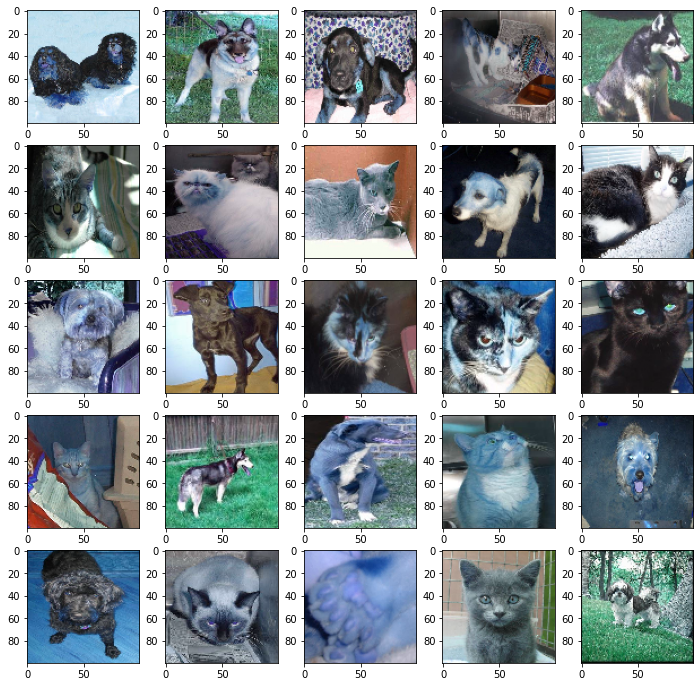

In [ ]:
# Show some example images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])

In [ ]:
# Create model
model = initialize_simplified_VGG(ROWS, COLS, CHANNELS)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',  # Sparse for integers, just categorical for one hot encoded
              metrics=['accuracy'])

#model.summary()

In [ ]:
# Split traindata again into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [ ]:
# Create augmentation generator
aug = ImageDataGenerator(
    rotation_range=rotation_range,
		zoom_range=zoom_range,
		width_shift_range=width_shift_range,
		height_shift_range=height_shift_range,
		shear_range=shear_range,
		horizontal_flip=horizontal_flip,
		fill_mode=fill_mode
)

Epoch 1/5
633/633 [==============================] - 44s 69ms/step - loss: 0.6925 - accuracy: 0.5378
Epoch 2/5
633/633 [==============================] - 43s 68ms/step - loss: 0.6791 - accuracy: 0.5682
Epoch 3/5
633/633 [==============================] - 43s 68ms/step - loss: 0.6701 - accuracy: 0.5930
Epoch 4/5
633/633 [==============================] - 43s 67ms/step - loss: 0.6862 - accuracy: 0.5470
Epoch 5/5
633/633 [==============================] - 43s 67ms/step - loss: 0.6935 - accuracy: 0.4961


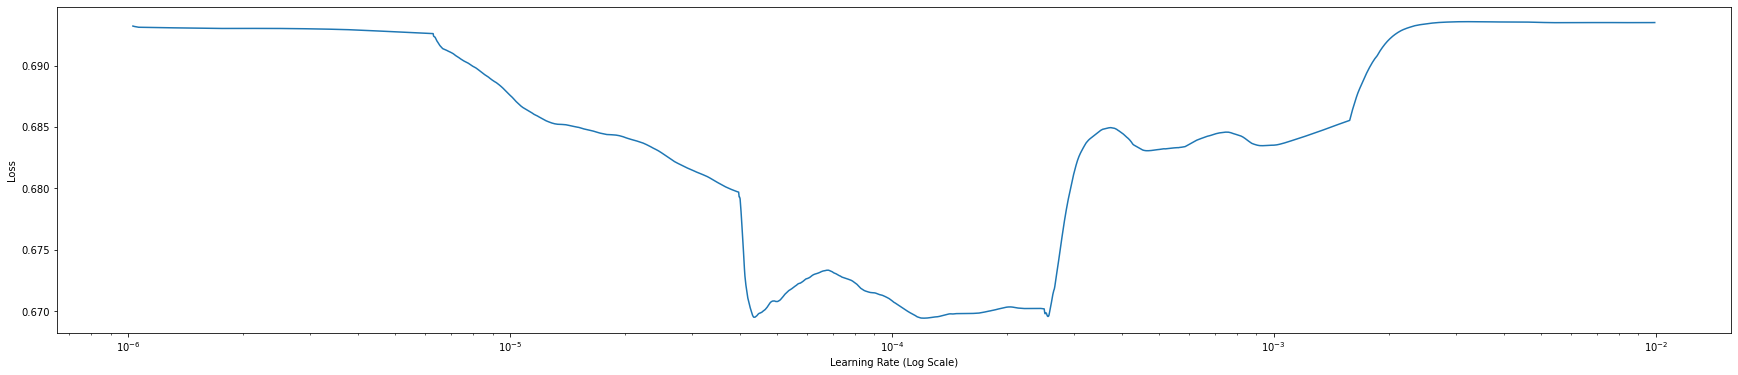

In [ ]:
lrf = LearningRateFinder(model, stopFactor=5)
lrf.find(aug.flow(X_train, y_train, batch_size=BATCHSIZE), 1e-6, 1e-2, stepsPerEpoch=np.ceil((len(X_train) / float(BATCHSIZE))), batchSize=BATCHSIZE, epochs=5)
lrf.plot_loss() #0, 0

In [ ]:
learnloss_df = pd.DataFrame({'learning_rate': lrf.lrs, 'loss': lrf.losses})
learnloss_df.shape

(3165, 2)

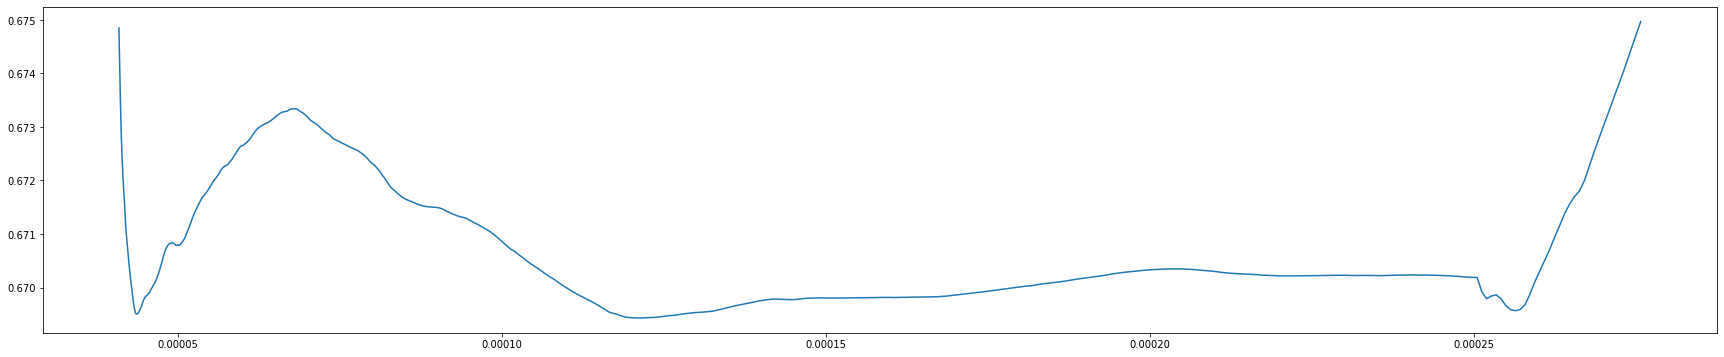

In [ ]:
plt.plot(learnloss_df.loc[learnloss_df['loss'] < 0.675, 'learning_rate'], learnloss_df.loc[learnloss_df['loss'] < 0.675, 'loss'])

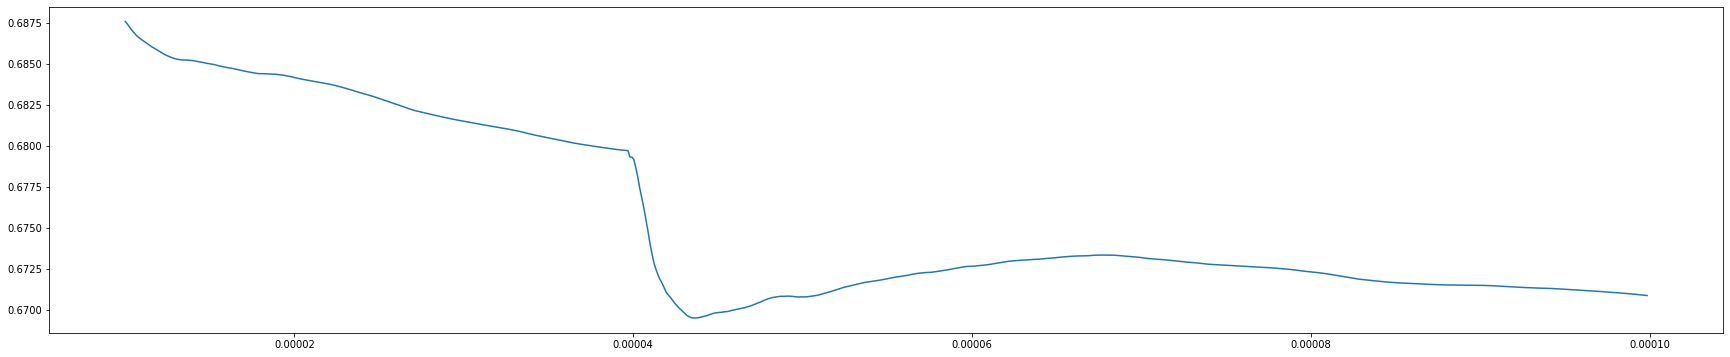

In [ ]:
plt.plot(learnloss_df.loc[(learnloss_df['learning_rate'] > 0.00001) & (learnloss_df['learning_rate'] < 0.0001), 'learning_rate'], 
         learnloss_df.loc[(learnloss_df['learning_rate'] > 0.00001) & (learnloss_df['learning_rate'] < 0.0001), 'loss'])

In [ ]:
min(lrf.lrs), max(lrf.lrs)

(1e-10, 9.900477)

In [ ]:
lrf.lrMult

1.0100535323371576

In [ ]:
# save best model checkpoint
save_model = tf.keras.callbacks.ModelCheckpoint('drive/My Drive/collab/vgg16_' + model_version + '.h5', monitor='val_accuracy', verbose=1, save_best_only=True, 
                                                save_weights_only=False, mode='auto', save_freq='epoch')

# Early stopping callback
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto')

# Cyclical learning rate callback
clr = CyclicLR(base_lr=MIN_LR, max_lr=MAX_LR, step_size=STEP_SIZE * -(-len(X_train)//BATCHSIZE), mode=CLR_METHOD, gamma=GAMMA)

In [ ]:
# Train model
start = datetime.datetime.now()
print(start)

history = model.fit(aug.flow(X_train, y_train, batch_size=BATCHSIZE),
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS, 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[clr, early, save_model]
                ) 

print('Finished in: {}'.format(datetime.datetime.now() - start))
print(datetime.datetime.now())

2020-10-14 14:46:31.670039
Epoch 1/64
633/633 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5546
Epoch 00001: val_accuracy improved from -inf to 0.56711, saving model to drive/My Drive/collab/vgg16_5.h5
633/633 [==============================] - 46s 73ms/step - loss: 0.6850 - accuracy: 0.5546 - val_loss: 0.6768 - val_accuracy: 0.5671
Epoch 2/64
633/633 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.5702
Epoch 00002: val_accuracy improved from 0.56711 to 0.57511, saving model to drive/My Drive/collab/vgg16_5.h5
633/633 [==============================] - 46s 73ms/step - loss: 0.6801 - accuracy: 0.5702 - val_loss: 0.6811 - val_accuracy: 0.5751
Epoch 3/64
633/633 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.5782
Epoch 00003: val_accuracy did not improve from 0.57511
633/633 [==============================] - 45s 72ms/step - loss: 0.6764 - accuracy: 0.5782 - val_loss: 0.6782 - val_accuracy: 0.5738
Epoch 4/64
633/6

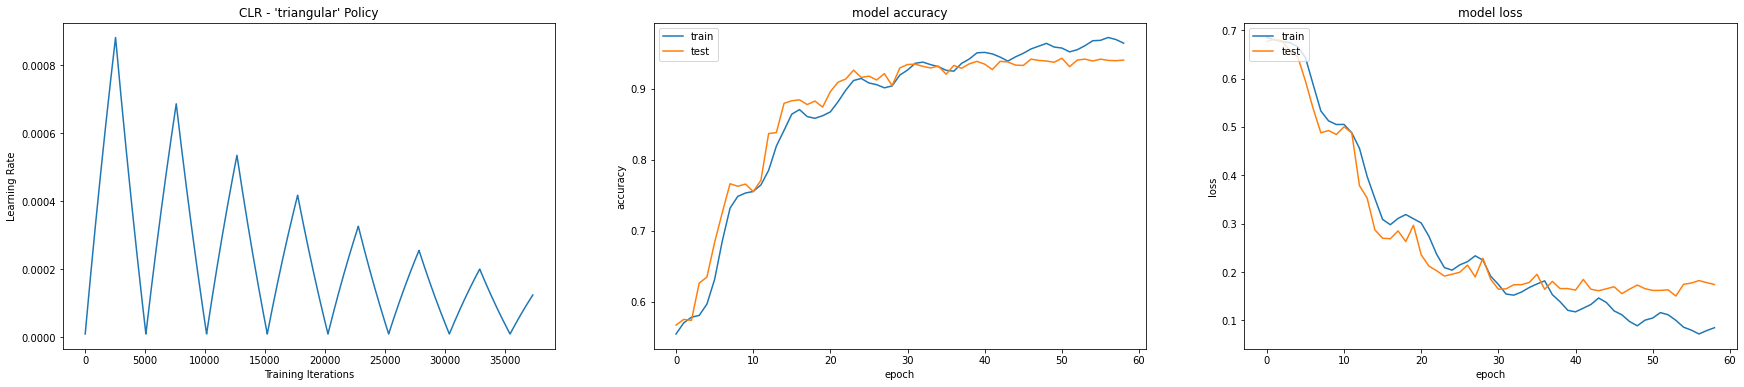

In [ ]:
training_history_plots(history, clr)

In [ ]:
# read in old saved model here
model = tf.keras.models.load_model('drive/My Drive/collab/vgg16_' + model_version + '.h5')

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 8ms/step - loss: 0.1538 - accuracy: 0.9436


In [ ]:
log_loss(y_test, model.predict(X_test))

0.15382576778090187

In [ ]:
# 0.8872, 0.358314 met alle seeds set
# 0.9176, 0.204827 added augmentation
# 0.9252, 0.215803 smaller aug higher epochs
# 0.9392, 0.165257 cyclical learning rate triangular 0.00001-0.001
# 0.9416, 0.152010 add two more cycles (16 epochs)

# 89.62% acc, 0.3547 loss score, learning rate 0.0001, 3,745,698 params full dataset

In [ ]:
#model.save('drive/My Drive/try_collab_gpu/simple_vgg3.h5')

In [ ]:
test_model = tf.keras.models.load_model('drive/My Drive/try_collab_gpu/simple_vgg.h5')

In [ ]:
log_loss(y_test, test_model.predict(X_test))

In [ ]:
comp_data = prep_data(test_images)

In [ ]:
# Normalize data
comp_data = comp_data / 255.0

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(comp_data[i])

In [ ]:
predictions_comp_data = pd.DataFrame({'id': range(1, len(comp_data) + 1), 'label': model.predict(comp_data)[:, 1]})
predictions_comp_data['label'] = round(predictions_comp_data['label'], 4)
predictions_comp_data.head(9)

In [ ]:
predictions_comp_data.describe()

In [ ]:
predictions_comp_data.to_csv('drive/My Drive/try_collab_gpu/submission_simple_vgg' + model_version + '.csv', index=False)

In [ ]:
! kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f 'drive/My Drive/try_collab_gpu/submission_simple_vgg' + model_version + '.csv' -m "triangular cycling lr more epochs"